# CSE 510 Reinforcement Learning Spring 2020 Assignment 3
# Policy Gradient & Actor-Critic - Part ONE (Policy Gradient)
## Srisai Karthik Neelamraju 50316785, neelamra@buffalo.edu

## REINFORCE algorithm for solving OpenAI CartPole

### Importing the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.distributions import Categorical
import gym
from collections import deque

### Defining the agent that implements Monte Carlo Policy Gradient (REINFORCE) algorithm

In [2]:
class RNFAgent:
    def __init__(self, env, alpha=0.01, gamma=0.99):
        # initializing a REINFORCE agent
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.n_input = self.env.observation_space.shape[0]
        self.n_actions = self.env.action_space.n
        self.curr_episode = []
        self.init_net()

    def init_net(self):
        class PolicyNetwork(nn.Module):
            def __init__(self, n_input=4, n_output=2):
                super(PolicyNetwork, self).__init__()
                self.l1 = nn.Linear(n_input, 10)
                self.l2 = nn.Linear(10, n_output)
            def forward(self, x):
                x = F.relu(self.l1(x))
                return F.softmax(self.l2(x), dim=-1)

        self.pnet = PolicyNetwork(self.n_input, self.n_actions)
        self.optimizer = Adam(self.pnet.parameters(), lr=self.alpha)

    def policy(self, state, test=False):
        state = torch.from_numpy(state).float()
        probs = self.pnet(state).data.numpy()
        if test:
            return np.argmax(probs)
        return np.random.choice(self.n_actions, p=probs)

    def store_transition(self, state, action, reward):
        self.curr_episode.append({'state': state,
                                  'action': action,
                                  'reward': reward})

    def train(self):
        """
            The idea of implementing the update step in the algorithm is referenced from the PyTorch documentation,
            available at https://pytorch.org/docs/stable/distributions.html#score-function
        """
        T = len(self.curr_episode)
        G = np.zeros(T)
        G[T - 1] = self.curr_episode[T - 1]['reward']
        for t in reversed(range(T - 1)):
            G[t] = self.curr_episode[t]['reward'] + self.gamma * G[t + 1]

        self.optimizer.zero_grad()
        for t in range(T):
            state = torch.from_numpy(self.curr_episode[t]['state']).float()
            action = torch.tensor(self.curr_episode[t]['action'])
            probs = self.pnet(state)
            dist = Categorical(probs)
            loss = - dist.log_prob(action) * G[t]
            loss.backward()
        self.optimizer.step()
        self.curr_episode = []

### Training the agent on the OpenAI CartPole environment

In [3]:
# initializing the Cartpole-v0 environment
env_cp = gym.make('CartPole-v0')

# initializing the REINFORCE agent
rnf_agent = RNFAgent(env_cp, alpha=0.01)

scores = []
avg_scores = []
last100_avg_scores = []

episodes = 1000
for episode in range(1, episodes + 1):
    state = env_cp.reset()
    done = False
    flag = False
    score = 0
    while not done:
        action = rnf_agent.policy(state)
        next_state, reward, done, _ = env_cp.step(action)
        if done and score != 199.0:
            reward = 0.0
            flag = True
        rnf_agent.store_transition(state.copy(), action, reward)
        np.copyto(state, next_state)
        score += reward if not flag else 1.0
    rnf_agent.train()
    scores.append(score)
    avg_scores.append(np.mean(scores))
    last100_avg_scores.append(np.mean(scores[-100:]))
    print("Episode: " + str(episode) + ", Score: " + str(score) + ", Avg Score: " + str(avg_scores[-1]) +
          ", Avg Score (Last 100 runs): " + str(last100_avg_scores[-1]))

C:\Users\neela\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode: 1, Score: 27.0, Avg Score: 27.0, Avg Score (Last 100 runs): 27.0
Episode: 2, Score: 16.0, Avg Score: 21.5, Avg Score (Last 100 runs): 21.5
Episode: 3, Score: 29.0, Avg Score: 24.0, Avg Score (Last 100 runs): 24.0
Episode: 4, Score: 14.0, Avg Score: 21.5, Avg Score (Last 100 runs): 21.5
Episode: 5, Score: 21.0, Avg Score: 21.4, Avg Score (Last 100 runs): 21.4
Episode: 6, Score: 10.0, Avg Score: 19.5, Avg Score (Last 100 runs): 19.5
Episode: 7, Score: 15.0, Avg Score: 18.857142857142858, Avg Score (Last 100 runs): 18.857142857142858
Episode: 8, Score: 11.0, Avg Score: 17.875, Avg Score (Last 100 runs): 17.875
Episode: 9, Score: 19.0, Avg Score: 18.0, Avg Score (Last 100 runs): 18.0
Episode: 10, Score: 22.0, Avg Score: 18.4, Avg Score (Last 100 runs): 18.4
Episode: 11, Score: 13.0, Avg Score: 17.90909090909091, Avg Score (Last 100 runs): 17.90909090909091
Episode: 12, Score: 13.0, Avg Score: 17.5, Avg Score (Last 100 runs): 17.5
Episode: 13, Score: 23.0, Avg Score: 17.92307692307

Episode: 87, Score: 51.0, Avg Score: 25.724137931034484, Avg Score (Last 100 runs): 25.724137931034484
Episode: 88, Score: 47.0, Avg Score: 25.96590909090909, Avg Score (Last 100 runs): 25.96590909090909
Episode: 89, Score: 24.0, Avg Score: 25.9438202247191, Avg Score (Last 100 runs): 25.9438202247191
Episode: 90, Score: 27.0, Avg Score: 25.955555555555556, Avg Score (Last 100 runs): 25.955555555555556
Episode: 91, Score: 34.0, Avg Score: 26.043956043956044, Avg Score (Last 100 runs): 26.043956043956044
Episode: 92, Score: 42.0, Avg Score: 26.217391304347824, Avg Score (Last 100 runs): 26.217391304347824
Episode: 93, Score: 61.0, Avg Score: 26.591397849462364, Avg Score (Last 100 runs): 26.591397849462364
Episode: 94, Score: 43.0, Avg Score: 26.76595744680851, Avg Score (Last 100 runs): 26.76595744680851
Episode: 95, Score: 43.0, Avg Score: 26.936842105263157, Avg Score (Last 100 runs): 26.936842105263157
Episode: 96, Score: 36.0, Avg Score: 27.03125, Avg Score (Last 100 runs): 27.0312

Episode: 176, Score: 145.0, Avg Score: 55.82386363636363, Avg Score (Last 100 runs): 79.56
Episode: 177, Score: 116.0, Avg Score: 56.163841807909606, Avg Score (Last 100 runs): 80.54
Episode: 178, Score: 161.0, Avg Score: 56.752808988764045, Avg Score (Last 100 runs): 81.81
Episode: 179, Score: 148.0, Avg Score: 57.262569832402235, Avg Score (Last 100 runs): 82.89
Episode: 180, Score: 127.0, Avg Score: 57.65, Avg Score (Last 100 runs): 83.75
Episode: 181, Score: 106.0, Avg Score: 57.9171270718232, Avg Score (Last 100 runs): 84.44
Episode: 182, Score: 189.0, Avg Score: 58.637362637362635, Avg Score (Last 100 runs): 85.87
Episode: 183, Score: 122.0, Avg Score: 58.98360655737705, Avg Score (Last 100 runs): 86.86
Episode: 184, Score: 111.0, Avg Score: 59.266304347826086, Avg Score (Last 100 runs): 87.7
Episode: 185, Score: 69.0, Avg Score: 59.31891891891892, Avg Score (Last 100 runs): 88.14
Episode: 186, Score: 164.0, Avg Score: 59.88172043010753, Avg Score (Last 100 runs): 89.51
Episode: 

Episode: 266, Score: 172.0, Avg Score: 79.54511278195488, Avg Score (Last 100 runs): 128.1
Episode: 267, Score: 200.0, Avg Score: 79.99625468164794, Avg Score (Last 100 runs): 128.1
Episode: 268, Score: 152.0, Avg Score: 80.26492537313433, Avg Score (Last 100 runs): 127.62
Episode: 269, Score: 200.0, Avg Score: 80.7100371747212, Avg Score (Last 100 runs): 129.42
Episode: 270, Score: 196.0, Avg Score: 81.13703703703703, Avg Score (Last 100 runs): 129.8
Episode: 271, Score: 166.0, Avg Score: 81.45018450184502, Avg Score (Last 100 runs): 130.16
Episode: 272, Score: 164.0, Avg Score: 81.75367647058823, Avg Score (Last 100 runs): 129.98
Episode: 273, Score: 200.0, Avg Score: 82.18681318681318, Avg Score (Last 100 runs): 130.68
Episode: 274, Score: 175.0, Avg Score: 82.52554744525547, Avg Score (Last 100 runs): 131.32
Episode: 275, Score: 163.0, Avg Score: 82.81818181818181, Avg Score (Last 100 runs): 130.95
Episode: 276, Score: 136.0, Avg Score: 83.01086956521739, Avg Score (Last 100 runs):

Episode: 355, Score: 128.0, Avg Score: 103.9887323943662, Avg Score (Last 100 runs): 175.81
Episode: 356, Score: 149.0, Avg Score: 104.11516853932584, Avg Score (Last 100 runs): 175.34
Episode: 357, Score: 162.0, Avg Score: 104.27731092436974, Avg Score (Last 100 runs): 175.47
Episode: 358, Score: 166.0, Avg Score: 104.44972067039106, Avg Score (Last 100 runs): 175.48
Episode: 359, Score: 167.0, Avg Score: 104.62395543175488, Avg Score (Last 100 runs): 175.52
Episode: 360, Score: 147.0, Avg Score: 104.74166666666666, Avg Score (Last 100 runs): 175.54
Episode: 361, Score: 162.0, Avg Score: 104.90027700831025, Avg Score (Last 100 runs): 175.46
Episode: 362, Score: 162.0, Avg Score: 105.05801104972376, Avg Score (Last 100 runs): 175.82
Episode: 363, Score: 161.0, Avg Score: 105.21212121212122, Avg Score (Last 100 runs): 175.65
Episode: 364, Score: 163.0, Avg Score: 105.37087912087912, Avg Score (Last 100 runs): 175.28
Episode: 365, Score: 154.0, Avg Score: 105.5041095890411, Avg Score (La

Episode: 443, Score: 200.0, Avg Score: 119.64559819413093, Avg Score (Last 100 runs): 177.64
Episode: 444, Score: 200.0, Avg Score: 119.82657657657657, Avg Score (Last 100 runs): 178.06
Episode: 445, Score: 200.0, Avg Score: 120.00674157303371, Avg Score (Last 100 runs): 178.8
Episode: 446, Score: 200.0, Avg Score: 120.18609865470852, Avg Score (Last 100 runs): 179.41
Episode: 447, Score: 200.0, Avg Score: 120.36465324384787, Avg Score (Last 100 runs): 180.11
Episode: 448, Score: 200.0, Avg Score: 120.54241071428571, Avg Score (Last 100 runs): 180.94
Episode: 449, Score: 200.0, Avg Score: 120.71937639198218, Avg Score (Last 100 runs): 181.59
Episode: 450, Score: 200.0, Avg Score: 120.89555555555556, Avg Score (Last 100 runs): 182.35
Episode: 451, Score: 200.0, Avg Score: 121.0709534368071, Avg Score (Last 100 runs): 182.89
Episode: 452, Score: 200.0, Avg Score: 121.24557522123894, Avg Score (Last 100 runs): 183.4
Episode: 453, Score: 200.0, Avg Score: 121.41942604856513, Avg Score (Las

Episode: 531, Score: 200.0, Avg Score: 132.49529190207156, Avg Score (Last 100 runs): 197.52
Episode: 532, Score: 200.0, Avg Score: 132.62218045112783, Avg Score (Last 100 runs): 197.52
Episode: 533, Score: 190.0, Avg Score: 132.7298311444653, Avg Score (Last 100 runs): 197.42
Episode: 534, Score: 200.0, Avg Score: 132.8558052434457, Avg Score (Last 100 runs): 197.42
Episode: 535, Score: 195.0, Avg Score: 132.97196261682242, Avg Score (Last 100 runs): 197.37
Episode: 536, Score: 200.0, Avg Score: 133.09701492537314, Avg Score (Last 100 runs): 197.37
Episode: 537, Score: 153.0, Avg Score: 133.1340782122905, Avg Score (Last 100 runs): 196.9
Episode: 538, Score: 200.0, Avg Score: 133.25836431226764, Avg Score (Last 100 runs): 196.9
Episode: 539, Score: 179.0, Avg Score: 133.34322820037104, Avg Score (Last 100 runs): 196.69
Episode: 540, Score: 148.0, Avg Score: 133.37037037037038, Avg Score (Last 100 runs): 196.17
Episode: 541, Score: 200.0, Avg Score: 133.49353049907577, Avg Score (Last 

Episode: 619, Score: 200.0, Avg Score: 140.91599353796445, Avg Score (Last 100 runs): 192.0
Episode: 620, Score: 200.0, Avg Score: 141.01129032258063, Avg Score (Last 100 runs): 192.0
Episode: 621, Score: 200.0, Avg Score: 141.10628019323673, Avg Score (Last 100 runs): 192.0
Episode: 622, Score: 200.0, Avg Score: 141.2009646302251, Avg Score (Last 100 runs): 192.0
Episode: 623, Score: 200.0, Avg Score: 141.29534510433388, Avg Score (Last 100 runs): 192.0
Episode: 624, Score: 200.0, Avg Score: 141.38942307692307, Avg Score (Last 100 runs): 192.0
Episode: 625, Score: 200.0, Avg Score: 141.4832, Avg Score (Last 100 runs): 192.0
Episode: 626, Score: 200.0, Avg Score: 141.57667731629394, Avg Score (Last 100 runs): 192.0
Episode: 627, Score: 200.0, Avg Score: 141.66985645933013, Avg Score (Last 100 runs): 192.72
Episode: 628, Score: 200.0, Avg Score: 141.76273885350318, Avg Score (Last 100 runs): 192.72
Episode: 629, Score: 200.0, Avg Score: 141.85532591414943, Avg Score (Last 100 runs): 192

Episode: 708, Score: 200.0, Avg Score: 148.21751412429379, Avg Score (Last 100 runs): 199.11
Episode: 709, Score: 103.0, Avg Score: 148.1537376586742, Avg Score (Last 100 runs): 198.14
Episode: 710, Score: 200.0, Avg Score: 148.22676056338028, Avg Score (Last 100 runs): 198.14
Episode: 711, Score: 200.0, Avg Score: 148.29957805907173, Avg Score (Last 100 runs): 198.14
Episode: 712, Score: 200.0, Avg Score: 148.37219101123594, Avg Score (Last 100 runs): 198.14
Episode: 713, Score: 200.0, Avg Score: 148.44460028050491, Avg Score (Last 100 runs): 198.14
Episode: 714, Score: 200.0, Avg Score: 148.51680672268907, Avg Score (Last 100 runs): 198.14
Episode: 715, Score: 200.0, Avg Score: 148.58881118881118, Avg Score (Last 100 runs): 198.14
Episode: 716, Score: 200.0, Avg Score: 148.66061452513966, Avg Score (Last 100 runs): 198.14
Episode: 717, Score: 198.0, Avg Score: 148.72942817294282, Avg Score (Last 100 runs): 198.12
Episode: 718, Score: 200.0, Avg Score: 148.8008356545961, Avg Score (La

Episode: 796, Score: 200.0, Avg Score: 152.4535175879397, Avg Score (Last 100 runs): 187.26
Episode: 797, Score: 200.0, Avg Score: 152.51317440401505, Avg Score (Last 100 runs): 187.26
Episode: 798, Score: 200.0, Avg Score: 152.57268170426065, Avg Score (Last 100 runs): 187.26
Episode: 799, Score: 200.0, Avg Score: 152.63204005006259, Avg Score (Last 100 runs): 187.26
Episode: 800, Score: 200.0, Avg Score: 152.69125, Avg Score (Last 100 runs): 187.26
Episode: 801, Score: 184.0, Avg Score: 152.73033707865167, Avg Score (Last 100 runs): 187.1
Episode: 802, Score: 200.0, Avg Score: 152.78927680798006, Avg Score (Last 100 runs): 187.1
Episode: 803, Score: 200.0, Avg Score: 152.8480697384807, Avg Score (Last 100 runs): 187.1
Episode: 804, Score: 200.0, Avg Score: 152.90671641791045, Avg Score (Last 100 runs): 187.1
Episode: 805, Score: 198.0, Avg Score: 152.96273291925465, Avg Score (Last 100 runs): 187.08
Episode: 806, Score: 200.0, Avg Score: 153.02109181141438, Avg Score (Last 100 runs):

Episode: 884, Score: 200.0, Avg Score: 157.01244343891403, Avg Score (Last 100 runs): 197.44
Episode: 885, Score: 200.0, Avg Score: 157.06101694915253, Avg Score (Last 100 runs): 198.09
Episode: 886, Score: 200.0, Avg Score: 157.1094808126411, Avg Score (Last 100 runs): 198.18
Episode: 887, Score: 200.0, Avg Score: 157.15783540022548, Avg Score (Last 100 runs): 198.18
Episode: 888, Score: 200.0, Avg Score: 157.2060810810811, Avg Score (Last 100 runs): 198.4
Episode: 889, Score: 200.0, Avg Score: 157.25421822272216, Avg Score (Last 100 runs): 198.4
Episode: 890, Score: 200.0, Avg Score: 157.30224719101125, Avg Score (Last 100 runs): 198.4
Episode: 891, Score: 200.0, Avg Score: 157.35016835016836, Avg Score (Last 100 runs): 198.46
Episode: 892, Score: 200.0, Avg Score: 157.39798206278027, Avg Score (Last 100 runs): 198.46
Episode: 893, Score: 200.0, Avg Score: 157.44568868980963, Avg Score (Last 100 runs): 198.46
Episode: 894, Score: 200.0, Avg Score: 157.49328859060404, Avg Score (Last 

Episode: 972, Score: 200.0, Avg Score: 160.90432098765433, Avg Score (Last 100 runs): 200.0
Episode: 973, Score: 200.0, Avg Score: 160.94450154162385, Avg Score (Last 100 runs): 200.0
Episode: 974, Score: 200.0, Avg Score: 160.98459958932239, Avg Score (Last 100 runs): 200.0
Episode: 975, Score: 200.0, Avg Score: 161.02461538461537, Avg Score (Last 100 runs): 200.0
Episode: 976, Score: 200.0, Avg Score: 161.06454918032787, Avg Score (Last 100 runs): 200.0
Episode: 977, Score: 200.0, Avg Score: 161.10440122824974, Avg Score (Last 100 runs): 200.0
Episode: 978, Score: 200.0, Avg Score: 161.14417177914112, Avg Score (Last 100 runs): 200.0
Episode: 979, Score: 200.0, Avg Score: 161.18386108273748, Avg Score (Last 100 runs): 200.0
Episode: 980, Score: 200.0, Avg Score: 161.2234693877551, Avg Score (Last 100 runs): 200.0
Episode: 981, Score: 200.0, Avg Score: 161.26299694189603, Avg Score (Last 100 runs): 200.0
Episode: 982, Score: 200.0, Avg Score: 161.30244399185335, Avg Score (Last 100 ru

### Visualizing the scores while training the agent

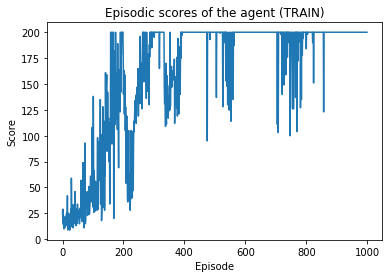

In [4]:
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Episodic scores of the agent (TRAIN)')
plt.plot(scores)
plt.show()

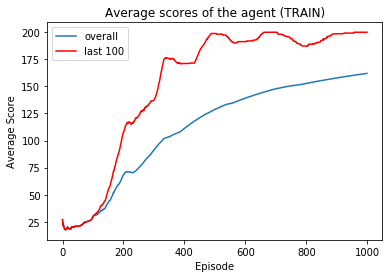

In [5]:
plt.plot(avg_scores, label='overall')
plt.plot(last100_avg_scores, color='red', label='last 100')
plt.xlabel('Episode')
plt.ylabel('Average Score')
plt.title('Average scores of the agent (TRAIN)')
plt.legend(loc='upper left')
plt.show()

### Observing performance of the trained agent for 100 episodes

In [6]:
test_scores = []

print("Testing the performance of the trained REINFORCE agent\n")

episodes = 100
for episode in range(1, episodes + 1):
    state = env_cp.reset()
    done = False
    score = 0
    while not done:
        action = rnf_agent.policy(state, test=True)
        next_state, reward, done, _ = env_cp.step(action)
        np.copyto(state, next_state)
        score += reward
    test_scores.append(score)
    print("Episode: " + str(episode) + ", Score: " + str(score))

print("Avg Score over 100 test episodes: " + str(np.mean(test_scores)))

Testing the performance of the trained REINFORCE agent

Episode: 1, Score: 200.0
Episode: 2, Score: 200.0
Episode: 3, Score: 200.0
Episode: 4, Score: 200.0
Episode: 5, Score: 200.0
Episode: 6, Score: 200.0
Episode: 7, Score: 200.0
Episode: 8, Score: 200.0
Episode: 9, Score: 200.0
Episode: 10, Score: 200.0
Episode: 11, Score: 200.0
Episode: 12, Score: 200.0
Episode: 13, Score: 200.0
Episode: 14, Score: 200.0
Episode: 15, Score: 200.0
Episode: 16, Score: 200.0
Episode: 17, Score: 200.0
Episode: 18, Score: 200.0
Episode: 19, Score: 200.0
Episode: 20, Score: 200.0
Episode: 21, Score: 200.0
Episode: 22, Score: 200.0
Episode: 23, Score: 200.0
Episode: 24, Score: 200.0
Episode: 25, Score: 200.0
Episode: 26, Score: 200.0
Episode: 27, Score: 200.0
Episode: 28, Score: 200.0
Episode: 29, Score: 200.0
Episode: 30, Score: 200.0
Episode: 31, Score: 200.0
Episode: 32, Score: 200.0
Episode: 33, Score: 200.0
Episode: 34, Score: 200.0
Episode: 35, Score: 200.0
Episode: 36, Score: 200.0
Episode: 37, Scor

### Visualizing the scores while testing the agent

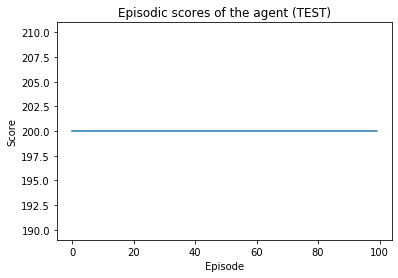

In [7]:
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Episodic scores of the agent (TEST)')
plt.plot(test_scores)
plt.show()